In [63]:
# %matplotlib inline
import sys
sys.path.insert(1, '/data/vision/polina/scratch/wpq/github/code_snippets')
from code_snippets.plot import plt_slices, plt_scaled_colobar_ax
from code_snippets.torch import torch_set_random_seed, torch_configure_cuda
from code_snippets.jpt import jpt_autoreload, jpt_full_width, jpt_in_notebook

jpt_autoreload()
jpt_full_width()

import matplotlib.pyplot as plt

# matplotlib.use("Agg", warn=True)

import json
import math
import os

import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score

import torch
import torch.utils.data
from torch import nn, optim
import torch.distributions as dist
from torch.optim.lr_scheduler import StepLR

from trixi.logger.experiment.pytorchexperimentlogger import PytorchExperimentLogger
from trixi.logger import PytorchVisdomLogger
from trixi.util import Config
from trixi.util.pytorchutils import set_seed

from models.enc_dec import Encoder, Generator
from data.brain_ds import BrainDataSet, load_dataset
from utils.util import smooth_tensor, normalize, find_best_val, calc_hard_dice

from brats_script import VAE, loss_function, get_inpt_grad, train, test_slice, test_pixel, model_run

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
gpu_id = '3'
patch_size = 256 # patch_size = 64
batch_size = 64
odd_class = 0
z = 256
seed = 123
log_var_std = 0.
n_epochs = 5
lr = 1e-4

model_h_size = (16, 32, 64, z)
exp_name = 'exp'
folder_name = f'exp_imsize={patch_size}'
checkpoint_path = '/data/vision/polina/scratch/wpq/github/vae-anomaly-experiments/exp/20220221-024447_exp/checkpoint/vae.pth'

torch_set_random_seed(seed)
device = torch_configure_cuda(gpu_id)

config = Config(
    exp_name=exp_name,
    patch_size=patch_size,
    batch_size=batch_size,
    odd_class=odd_class,
    z=z,
    seed=seed,
    log_var_std=log_var_std,
    n_epochs=n_epochs
)

input_shape = (batch_size, 1, patch_size, patch_size)

config, device, input_shape

({'exp_name': 'exp',
  'patch_size': 256,
  'batch_size': 64,
  'odd_class': 0,
  'z': 256,
  'seed': 123,
  'log_var_std': 0.0,
  'n_epochs': 5},
 device(type='cuda'),
 (64, 1, 256, 256))

In [13]:
datasets_common_args = {
    "batch_size": batch_size,
    "target_size": patch_size,
    "input_slice": [0, ],  # [1, ] previously selects T2 mri
    "add_noise": True,
    "mask_type": "gaussian",  # 0.0, ## TODO
    "elastic_deform": False,
    "rnd_crop": True,
    "rotate": True,
    "color_augment": True,
    "add_slices": 0,
}

proj_dir = '/data/vision/polina/scratch/wpq/github/vae-anomaly-experiments/'
num_batches = 3 if jpt_in_notebook() else None

train_set_args = {
    "base_dir": os.path.join(proj_dir, "data/hcp1200_v2/"),
    "num_batches": num_batches, # 500
    "slice_offset": 50, # 20
    "num_processes": 8, # 8
}

test_set_normal_args = {
    "base_dir": os.path.join(proj_dir, "data/atlas2/"),  # brats17/
    "num_batches": num_batches, # 100
    "do_reshuffle": False,
    "mode": "val",
    "num_processes": 2, # 2
    "slice_offset": 30, # 20
    "label_slice": 2,
    "only_labeled_slices": False,
}

test_set_unormal_args = {
    "base_dir": os.path.join(proj_dir, "data/atlas2/"),  # brats17/
    "num_batches": num_batches,  # 100
    "do_reshuffle": False,
    "mode": "val",
    "num_processes": 2, # 2
    "slice_offset": 30, # 20
    "label_slice": 2,
    "only_labeled_slices": True,
    "labeled_threshold": 10,
}

test_set_all_args = {
    "base_dir": os.path.join(proj_dir, "data/atlas2/"),  # brats17/
    "num_batches": num_batches, # 50
    "do_reshuffle": False,
    "mode": "val",
    "num_processes": 2, # 2
    "slice_offset": 30, # 20
    "label_slice": 2,
}

In [14]:
train_loader = BrainDataSet(**datasets_common_args, **train_set_args)
test_loader_normal = BrainDataSet(**datasets_common_args, **test_set_normal_args)
test_loader_abnorm = BrainDataSet(**datasets_common_args, **test_set_unormal_args)
test_loader_all = BrainDataSet(**datasets_common_args, **test_set_all_args)

In [195]:
test_set_all_args_ = test_set_all_args
test_set_all_args_['num_batches'] = None
test_loader_all_ = BrainDataSet(**datasets_common_args, **test_set_all_args_)

In [16]:
from brats_script import VAE
model = VAE(input_size=input_shape[1:], h_size=model_h_size, z_dim=z).to(device)
if checkpoint_path != '':
    model.load_state_dict(torch.load(checkpoint_path))
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = StepLR(optimizer, step_size=1)

In [71]:
# vlog = PytorchVisdomLogger(experiment_name=exp_name)
vlog = None
elog = PytorchExperimentLogger(base_dir=folder_name, experiment_name=exp_name)
elog.save_config(config, "config")

In [12]:

for epoch in range(1, n_epochs + 1):
    #     train(epoch, model, optimizer, train_loader, device, vlog, elog, log_var_std)
    #
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data["data"][0].float().to(device)
        optimizer.zero_grad()
        recon_batch, mu, logstd = model(data)
        loss, kl, rec = loss_function(recon_batch, data, mu, logstd, log_var_std)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx}/{len(train_loader)} ({100. * batch_idx / len(train_loader):.0f}%)]'
                  f'\tLoss: {loss.item() / len(data):.6f}'
                  f'\tKL,Rec,Total: {torch.mean(kl).item():.3f}, {torch.mean(rec).item():.3f}, {loss.item():.3f}')
            
            # vlog.show_value(torch.mean(kl).item(), name="Kl-loss", tag="Losses")
            # vlog.show_value(torch.mean(rec).item(), name="Rec-loss", tag="Losses")
            # vlog.show_value(loss.item(), name="Total-loss", tag="Losses")

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader)))
    


Reshuffle...
Train Epoch: 1 [0/3 (0%)]	Loss: 1056.103271	KL,Rec,Total: 561.353, 67029.250, 67590.609
====> Epoch: 1 Average loss: 68246.4089
Reshuffle...
Train Epoch: 2 [0/3 (0%)]	Loss: 1050.456055	KL,Rec,Total: 390.860, 66838.328, 67229.188
====> Epoch: 2 Average loss: 68049.3490
Reshuffle...
Train Epoch: 3 [0/3 (0%)]	Loss: 1077.588257	KL,Rec,Total: 165.527, 68800.117, 68965.648
====> Epoch: 3 Average loss: 68600.4557
Reshuffle...
Train Epoch: 4 [0/3 (0%)]	Loss: 1051.240112	KL,Rec,Total: 73.980, 67205.391, 67279.367
====> Epoch: 4 Average loss: 69133.2682
Reshuffle...
Train Epoch: 5 [0/3 (0%)]	Loss: 1035.193848	KL,Rec,Total: 19.418, 66232.984, 66252.406
====> Epoch: 5 Average loss: 67021.0130


In [13]:
kl_roc, rec_roc, loss_roc, kl_pr, rec_pr, loss_pr, test_loss = test_slice(
    model, test_loader_normal,
    test_loader_abnorm, device,
    vlog, elog, input_shape, batch_size,
    log_var_std)

====> Test set loss: 64976.3647


In [14]:
with open(os.path.join(elog.result_dir, "results.json"), "w") as file_:
    json.dump({
        "kl_roc": kl_roc, "rec_roc": rec_roc, "loss_roc": loss_roc,
        "kl_pr": kl_pr, "rec_pr": rec_pr, "loss_pr": loss_pr,
    }, file_, indent=4)

elog.save_model(model, "vae")

In [15]:
test_pixel(model, test_loader_all, device, vlog, elog, input_shape, batch_size, log_var_std)

print("All done....")

All done....


In [77]:
# kl_roc, rec_roc, loss_roc, kl_pr, rec_pr, loss_pr, test_loss = test_slice(
#     model, test_loader_normal,
#     test_loader_abnorm, device,
#     vlog, elog, input_shape, batch_size,
#     log_var_std)

model.eval()
test_loss = []
kl_loss = []
rec_loss = []
with torch.no_grad():
    for i, data in enumerate(test_loader_normal):
        data = data["data"][0].float().to(device)
        recon_batch, mu, logstd = model(data)
        loss, kl, rec = loss_function(recon_batch, data, mu, logstd, log_var_std)
        test_loss += (kl + rec).tolist() # average loss.
        kl_loss += kl.tolist()
        rec_loss += rec.tolist()


test_loss_ab = []
kl_loss_ab = []
rec_loss_ab = []
with torch.no_grad():
    for i, data in enumerate(test_loader_abnorm):
        data = data["data"][0].float().to(device)
        recon_batch, mu, logstd = model(data)
        loss, kl, rec = loss_function(recon_batch, data, mu, logstd, log_var_std)
        test_loss_ab += (kl + rec).tolist()
        kl_loss_ab += kl.tolist()
        rec_loss_ab += rec.tolist()

elog.print(f'Test Normal Average Loss: {np.mean(test_loss):.4f}')
elog.print(f'Test Abnorm Average Loss: {np.mean(test_loss_ab):.4f}')

def compute_roc_ap(a, b):
    label = [0]*len(a) + [1]*len(b)
    score = a + b
    roc = roc_auc_score(label, score)
    ap = average_precision_score(label, score)
    return roc, ap

kl_roc, kl_pr = compute_roc_ap(kl_loss, kl_loss_ab)
rec_roc, rec_pr = compute_roc_ap(rec_loss, rec_loss_ab)
loss_roc, loss_pr = compute_roc_ap(test_loss, test_loss_ab)

kl_roc, rec_roc, loss_roc

Test Normal Average Loss: 62944.5776
Test Abnorm Average Loss: 64666.7975


(192, 192)

In [ ]:
# def test_pixel(model, test_loader_pixel, device, vlog, elog, image_size, batch_size, log_var_std):

model.eval()

test_loss = []
kl_loss = []
rec_loss = []

pixel_class = []
pixel_rec_err = []
pixel_grad_all = []
pixel_grad_kl = []
pixel_grad_rec = []
pixel_combi_err = []

with torch.no_grad():
    for i, data in enumerate(test_loader_all_):
        
        inpt = data["data"][0].float().to(device)
        seg = data["seg"].float()[0, :, 0] # (1, bsz, 1, 256, 256) -> (bsz, 256, 256)
        seg_flat = seg.flatten() > 0.5
        pixel_class += seg_flat.tolist()

        recon_batch, mu, logstd = model(inpt)

        loss, kl, rec = loss_function(recon_batch, inpt, mu, logstd, log_var_std, sum_samplewise=False)
        rec = rec.detach().cpu()
        pixel_rec_err += rec.flatten().tolist()

        def __err_fn_all(x, loss_idx=0):  # loss_idx 0: elbo, 1: kl part, 2: rec part
            outpt = model(x)
            recon_batch, mu, logstd = outpt
            loss = loss_function(recon_batch, x, mu, logstd, log_var_std)
            return torch.mean(loss[loss_idx])

        with torch.enable_grad():
            loss_grad_all = get_inpt_grad(model=model, inpt=inpt, err_fn=lambda x: __err_fn_all(x, 0),
                                          ).detach().cpu()
            loss_grad_kl = get_inpt_grad(model=model, inpt=inpt, err_fn=lambda x: __err_fn_all(x, 1),
                                         ).detach().cpu()
            loss_grad_rec = get_inpt_grad(model=model, inpt=inpt, err_fn=lambda x: __err_fn_all(x, 2),
                                          ).detach().cpu()

        pixel_grad_all += smooth_tensor(loss_grad_all).flatten().tolist()
        pixel_grad_kl += smooth_tensor(loss_grad_kl).flatten().tolist()
        pixel_grad_rec += smooth_tensor(loss_grad_rec).flatten().tolist()
        pixel_combi_err += (smooth_tensor(normalize(loss_grad_kl)) * rec).flatten().tolist()

kl_normalized = np.asarray(pixel_grad_kl)
kl_normalized = (kl_normalized - np.min(kl_normalized)) / (np.max(kl_normalized) - np.min(kl_normalized))
rec_normalized = np.asarray(pixel_rec_err)
rec_normalized = (rec_normalized - np.min(rec_normalized)) / (np.max(rec_normalized) - np.min(rec_normalized))
combi_add = kl_normalized + rec_normalized


rec_err_roc, rec_err_pr = elog.get_classification_metrics(pixel_rec_err, pixel_class)[0]
grad_all_roc, grad_all_pr = elog.get_classification_metrics(pixel_grad_all, pixel_class)[0]
grad_kl_roc, grad_kl_pr = elog.get_classification_metrics(pixel_grad_kl, pixel_class)[0]
grad_rec_roc, grad_rec_pr = elog.get_classification_metrics(pixel_grad_rec, pixel_class)[0]
pixel_combi_roc, pixel_combi_pr = elog.get_classification_metrics(pixel_combi_err, pixel_class)[0]
add_combi_roc, add_combi_pr = elog.get_classification_metrics(combi_add, pixel_class)[0]

rec_err_dice, reconst_thres = find_best_val(pixel_rec_err, pixel_class, calc_hard_dice, max_steps=8,
                                            val_range=(0, np.max(pixel_rec_err)))
grad_kl_dice, grad_kl_thres = find_best_val(pixel_grad_kl, pixel_class, calc_hard_dice, max_steps=8,
                                            val_range=(0, np.max(pixel_grad_kl)))
pixel_combi_dice, pixel_combi_thres = find_best_val(pixel_combi_err, pixel_class, calc_hard_dice, max_steps=8,
                                                    val_range=(0, np.max(pixel_combi_err)))
add_combi_dice, _ = find_best_val(combi_add, pixel_class, calc_hard_dice, max_steps=8,
                                  val_range=(0, np.max(combi_add)))

results = {
    "rec_err_roc": rec_err_roc, "rec_err_pr": rec_err_pr,
    "grad_all_roc": grad_all_roc, "grad_all_pr": grad_all_pr,
    "grad_kl_roc": grad_kl_roc, "grad_kl_pr": grad_kl_pr,
    "grad_rec_roc": grad_rec_roc, "grad_rec_pr": grad_rec_pr,
    "pixel_combi_roc": pixel_combi_roc, "pixel_combi_pr": pixel_combi_pr,
    "rec_err_dice": rec_err_dice, "grad_kl_dice": grad_kl_dice, "pixel_combi_dice":
        pixel_combi_dice,

}
results

In [194]:

# rec_err_dice, reconst_thres = find_best_val(pixel_rec_err, pixel_class, calc_hard_dice, max_steps=8,
#                                             val_range=(0, np.max(pixel_rec_err)))
# grad_kl_dice, grad_kl_thres = find_best_val(pixel_grad_kl, pixel_class, calc_hard_dice, max_steps=8,
#                                             val_range=(0, np.max(pixel_grad_kl)))
# pixel_combi_dice, pixel_combi_thres = find_best_val(pixel_combi_err, pixel_class, calc_hard_dice, max_steps=8,
#                                                     val_range=(0, np.max(pixel_combi_err)))
# add_combi_dice, _ = find_best_val(combi_add, pixel_class, calc_hard_dice, max_steps=8,
#                                   val_range=(0, np.max(combi_add)))

{
    "rec_err_roc": rec_err_roc, "rec_err_pr": rec_err_pr,
    "grad_all_roc": grad_all_roc, "grad_all_pr": grad_all_pr,
    "grad_kl_roc": grad_kl_roc, "grad_kl_pr": grad_kl_pr,
    "grad_rec_roc": grad_rec_roc, "grad_rec_pr": grad_rec_pr,
    "pixel_combi_roc": pixel_combi_roc, "pixel_combi_pr": pixel_combi_pr,
    "rec_err_dice": rec_err_dice, "grad_kl_dice": grad_kl_dice, "pixel_combi_dice":
        pixel_combi_dice,

}


{'rec_err_roc': 0.8089217506750472,
 'rec_err_pr': 0.012212653565443736,
 'grad_all_roc': 0.797208814980606,
 'grad_all_pr': 0.013421447287771863,
 'grad_kl_roc': 0.9295363159940301,
 'grad_kl_pr': 0.0797209365153063,
 'grad_rec_roc': 0.7968009205428942,
 'grad_rec_pr': 0.013386817829423591,
 'pixel_combi_roc': 0.9396513473025906,
 'pixel_combi_pr': 0.05006756610996948,
 'rec_err_dice': 0.0377211757004261,
 'grad_kl_dice': 0.16332900524139404,
 'pixel_combi_dice': 0.11041370034217834}

/tmp/ipykernel_19326/637745248.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(2,3,figsize=(30,20))


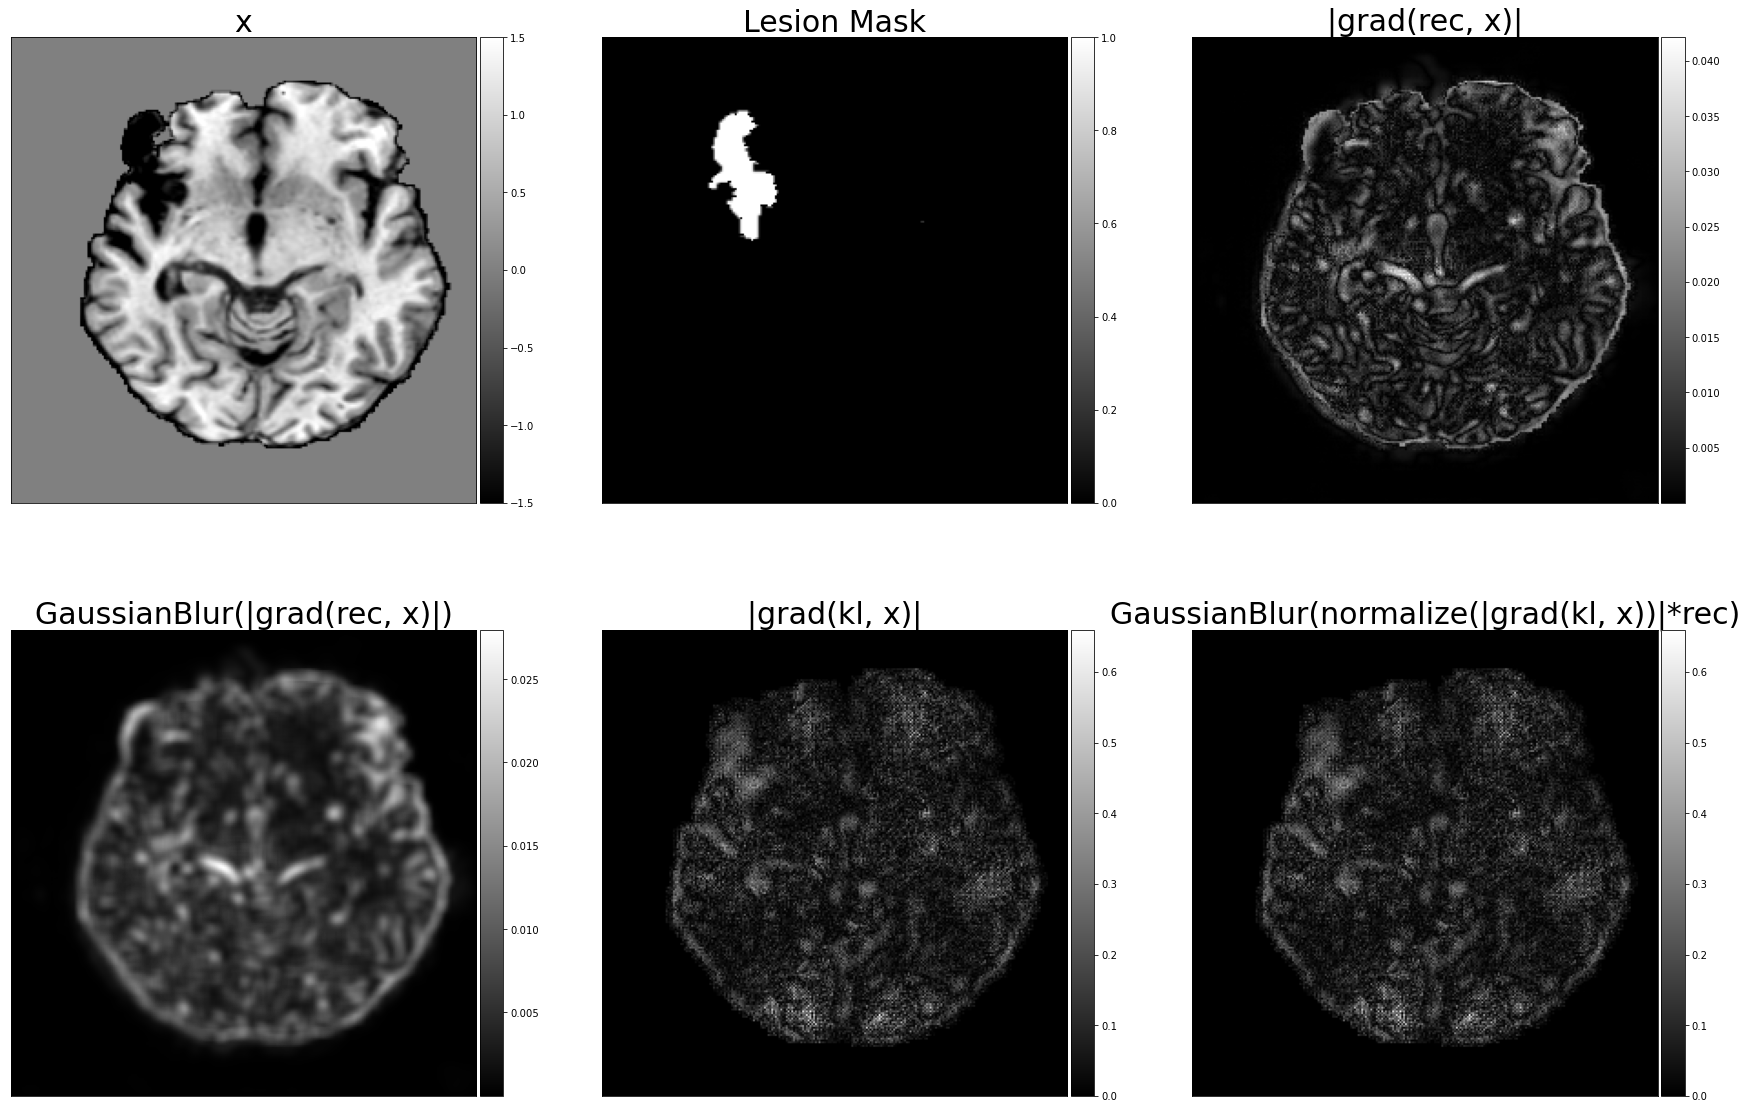

In [191]:
idx = 60

fig, axs = plt.subplots(2,3,figsize=(30,20))
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

ax = axs[0,0]
im = ax.imshow(data['data'].to('cpu').numpy().squeeze()[idx], cmap='gray')
fig.colorbar(im, cax=plt_scaled_colobar_ax(ax))
ax.set_title('x', fontsize=30)

ax = axs[0,1]
im = ax.imshow(data['seg'].to('cpu').numpy().squeeze()[idx], cmap='gray')
fig.colorbar(im, cax=plt_scaled_colobar_ax(ax))
ax.set_title('Lesion Mask', fontsize=30)

ax = axs[0,2]
im = ax.imshow(loss_grad_all.to('cpu').numpy().squeeze()[idx], cmap='gray')
fig.colorbar(im, cax=plt_scaled_colobar_ax(ax))
ax.set_title('|grad(rec, x)|', fontsize=30)

ax = axs[1,0]
im = ax.imshow(smooth_tensor(loss_grad_all).to('cpu').numpy().squeeze()[idx], cmap='gray')
fig.colorbar(im, cax=plt_scaled_colobar_ax(ax))
ax.set_title('GaussianBlur(|grad(rec, x)|)', fontsize=30)

ax = axs[1,1]
im = ax.imshow(loss_grad_kl.to('cpu').numpy().squeeze()[idx], cmap='gray')
fig.colorbar(im, cax=plt_scaled_colobar_ax(ax))
ax.set_title('|grad(kl, x)|', fontsize=30)

ax = axs[1,2]
im = ax.imshow(loss_grad_kl.to('cpu').numpy().squeeze()[idx], cmap='gray')
fig.colorbar(im, cax=plt_scaled_colobar_ax(ax))
ax.set_title('GaussianBlur(normalize(|grad(kl, x))|*rec)', fontsize=30)

fig

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(518, 2066, 3) 0.0 1.1094548


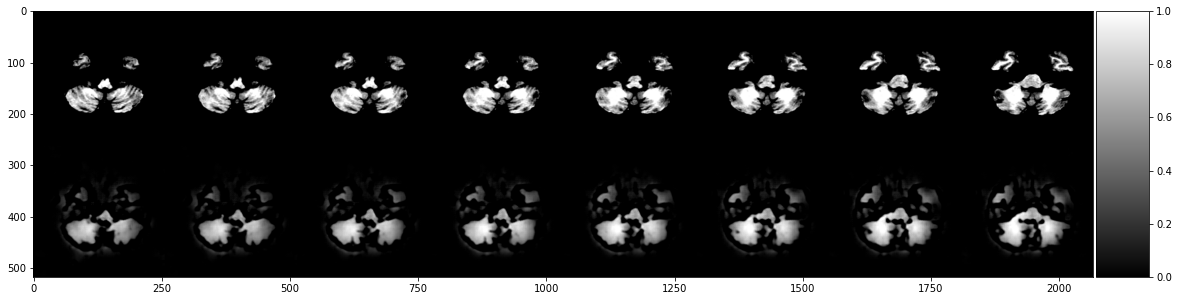

In [66]:


def normalize_dmoyer(vol):
    """ Normalize volume `vol` by clipping extreme values 
        such that intensities roughly lies in the [0, 1] range 
        `vol_max` and `vol_denom` different to preserve dynamic range
    """
    vol = np.copy(vol)
    vol_max = np.quantile(vol,0.995)
    vol_denom = np.quantile(vol,0.99)
    vol = np.clip(vol, 0, vol_max)
    vol /= vol_denom
    return vol


import torchvision
c = torch.cat([data[:8], recon_batch[:8]])
c = torchvision.utils.make_grid(comparison).to('cpu').detach()
c = normalize_dmoyer(c.numpy())
c = c.transpose((1,2,0))
print(c.shape, c.min(), c.max())
fig, ax = plt.subplots(1,1,figsize=(20,5))
im = ax.imshow(c, cmap='gray')
fig.colorbar(im, cax=plt_scaled_colobar_ax(ax))
fig




(64, 260, 260)


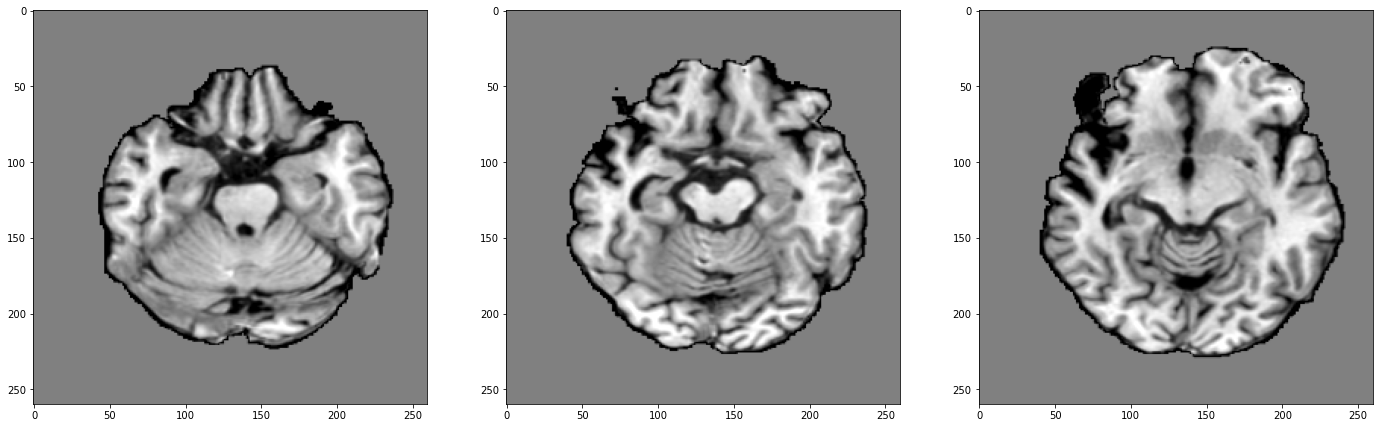

In [9]:
# x = train_loader[0]['data'].numpy().squeeze()
# x = test_loader_normal[0]['data'].numpy().squeeze()
# x = test_loader_abnorm[0]['data'].numpy().squeeze()
# x = test_loader_all[0]['data'].numpy().squeeze()

# print(x.shape)

# fig, axs = plt.subplots(1,3,figsize=(24,8))

# for i,k in enumerate([0,10,20]):
#     ax = axs[i]
#     ax.imshow(x[k], cmap='gray')

# fig

# for batch_idx, data in enumerate(train_loader):
#     data = data['data'][0].float()  # (1, 64, 1, 260, 260) -> (64, 1, 260, 260)
#     print(data.numpy().squeeze().shape)
#     break

In [28]:
# # files, file_len, slices = load_dataset(base_dir=train_set_args['base_dir'],
# #                                       pattern='*.npy',
# #                                       slice_offset=train_set_args['slice_offset'],
# #                                       only_labeled_slices=None,
# #                                       label_slice=None,
# #                                       labeled_threshold=10)
# import fnmatch

# #### hcp
# base_dir='data/hcp1200_v2'
# pattern='*.npy'
# slice_offset=50
# only_labeled_slices=None
# label_slice=None
# labeled_threshold=10
# #### atlas2 
# base_dir='data/atlas2'
# # pattern='*.npy'
# slice_offset=30
# only_labeled_slices=False # False selects healthy slices, True selects lesion slices
# label_slice=2
# labeled_threshold=10
# ####


# fls = []
# files_len = []
# slices = []

# for root, dirs, files in os.walk(base_dir):
#     for i, filename in enumerate(sorted(fnmatch.filter(files, pattern))):
#         npy_file = os.path.join(root, filename) # data/atlas2/sub-r001s001_ses-1.npy 
#         numpy_array = np.load(npy_file, mmap_mode="r") # (3, 260, 320, 260)

#         fls.append(npy_file)
#         files_len.append(numpy_array.shape[1])

#         if only_labeled_slices is None:
#             slices.extend([(i, j) for j in range(slice_offset, files_len[-1] - slice_offset)])
#         else:
#             assert label_slice is not None # label_slice access into lesion_mask

#             for s_idx in range(slice_offset, numpy_array.shape[1] - slice_offset):

#                 # `pixel_sum` is #pixels where lesion mask is active.
#                 # `only_labeled_slices=True`: selects 
#                 # 
#                 pixel_sum = np.sum(numpy_array[label_slice, s_idx] > 0.1)
#                 if pixel_sum > labeled_threshold:
#                     if only_labeled_slices is True:
#                         slices.append((i, s_idx))
#                 elif pixel_sum == 0:
#                     if only_labeled_slices is False:
#                         slices.append((i, s_idx))

#         break

# print(fls, files_len, slices, len(slices))

['data/atlas2/sub-r001s001_ses-1.npy'] [260] [(0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (0, 63), (0, 64), (0, 65), (0, 66), (0, 67), (0, 200), (0, 201), (0, 202), (0, 203), (0, 204), (0, 205), (0, 206), (0, 207), (0, 208), (0, 209), (0, 210), (0, 211), (0, 212), (0, 213), (0, 214), (0, 215), (0, 216), (0, 217), (0, 218), (0, 219), (0, 220), (0, 221), (0, 222), (0, 223), (0, 224), (0, 225), (0, 226), (0, 227), (0, 228), (0, 229)] 68


In [58]:
# self = train_loader.data_loader
# # self = test_loader_abnorm.data_loader

# ks = ['files', 'slices', 'batch_size', 'use_next', 'slice_idxs', 'n_items', 
#       'num_batches', 'input_slice', 'label_slice', 'add_slices', 'np_data']

# for k in ks:
#     attr = getattr(self, k)
#     if isinstance(attr, list):
#         print(f'{k}\t {len(attr)}, {attr[:5]}')
#     else:
#         print(f'{k}\t {attr}')
# print('\n')

# # Idea is `loader.__get_item__(self, i)` retrieves `loader.slices[i]`
# #
# assert(self.num_batches == (len(self.slices) // self.batch_size))
# #
# #
# # `slice_offset` exists to prevent using blank slices ...
# # self.add_slices := 0, whether input image has lots of slices
# # self.input_slice := [0,] picks what data type in np file, i.e., T1/T2/mask/lesion_mask
# # self.slice_idxs := 1...#slices. 
# #     - shuffling this array shuffles the data order.
# #     - indexes into self.np_data
# # self.np_data := [1...#vols] \prod [20...#slices/vol-20]

# # def __getitem__(self, item):
# item = 0
# start_idx = (item * self.batch_size) % self.data_len
# stop_idx  = ((item + 1) * self.batch_size) % self.data_len
# idxs = self.slice_idxs[start_idx:stop_idx]
# open_array = self.np_data[idxs]

# # def get_data_from_array(self, open_array):

# data = []
# fnames = []
# slice_idxs = []
# labels = []

# for slice in open_array: # [0,20]
#     fn_name = self.files[slice[0]] # data/hcp1200/100206.npy | data/atlas2/sub-r001s001_ses-1.npy
#     slice_idx = slice[1] # 20

#     # shape=(3, 260, 320, 260)
#     numpy_array = np.load(fn_name, mmap_mode="r")
#     # shape=(1, 1, 320, 260)
#     numpy_slice = numpy_array[self.input_slice,
#                               slice_idx - self.add_slices:slice_idx + self.add_slices + 1, ]
#     data.append(numpy_slice)

#     if self.label_slice is not None:
#         label_slice = numpy_array[self.label_slice,
#                                   slice_idx - self.add_slices:slice_idx + self.add_slices + 1, ]
#         labels.append(label_slice)

#     fnames.append(fn_name)
#     slice_idxs.append(slice_idx / 200.) # not really used in training code.
#     del numpy_array


# ret_dict = {'data': data,  # [ndarray,...], transform handles stacking and tranforming to batched tensor.
#             'fnames': fnames, 
#             'slice_idxs': slice_idxs}
# if self.label_slice is not None:
#     ret_dict['seg'] = labels

# ret_dict.keys()


files	 1064, ['data/hcp1200_v2/100206.npy', 'data/hcp1200_v2/100307.npy', 'data/hcp1200_v2/100408.npy', 'data/hcp1200_v2/100610.npy', 'data/hcp1200_v2/101006.npy']
slices	 170240, [(0, 50), (0, 51), (0, 52), (0, 53), (0, 54)]
batch_size	 64
use_next	 False
slice_idxs	 170240, [71584, 163882, 113298, 58460, 80117]
n_items	 2660
num_batches	 2660
input_slice	 1, [0]
label_slice	 None
add_slices	 0
np_data	 [[   0   50]
 [   0   51]
 [   0   52]
 ...
 [1063  207]
 [1063  208]
 [1063  209]]




dict_keys(['data', 'fnames', 'slice_idxs'])